# This notebook plots REMA elevations on ICESAT1 lines

based a bit on radarlines_over_REMA but trying to compare icesat1 lines to new REMA data

code to produce data at /Users/home/whitefar/DATA/code/REMOTE_SENSING/REMA/ICESAT1_lines_over_REMA.py

In all REMA code i use index from original file (REMA_Strip_Index_Rel1.shp) to refer to specific stripes 

In [9]:

import rasterio as rio
import rasterio.mask
import fiona
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
from scipy import interpolate

from shapely.geometry import LineString


gis_path ="/Users/home/whitefar/DATA/REMOTE_SENSING/ICESAT1/shapefiles_of_icesat1_over_channel/"
REMA_filepath = '/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/'

indicies_which_intersect_studyarea = np.loadtxt("/Users/home/whitefar/DATA/REMOTE_SENSING/REMA_2m_strips/indicies_which_intersect.txt").astype(int).tolist()
lines_files_paths = glob.glob(os.path.join(gis_path,"**.shp"),recursive=True)
lines_names = [os.path.splitext(os.path.split(line_file_path )[1])[0] for line_file_path in lines_files_paths]
REMA_shapes_df = gpd.read_file('/Users/home/whitefar/DATA/REMOTE_SENSING/REMA_2m_strips/REMA_Strip_Index_Rel1.shp',crs="EPSG:3031").iloc[indicies_which_intersect_studyarea]

In [10]:
#open the dictionary associating each line with REMA strips
with open(gis_path+'REMAnid_over_icesat1lines.txt','r') as f:
    ld = eval(f.read())


line_index = [x for x in zip(lines_names,range(len(lines_names)))]

#print the line names with an index
print(lines_names)

['track0099smoothpoints', 'track0211smoothpoints']


In [14]:
print(ld['track0099smoothpoints'],ld['track0211smoothpoints'])

['nid_122088', 'nid_131225', 'nid_131226', 'nid_131228', 'nid_145073', 'nid_145074', 'nid_159199', 'nid_159200', 'nid_159202'] ['nid_122088', 'nid_131225', 'nid_131226', 'nid_131228', 'nid_145073', 'nid_145074', 'nid_159199', 'nid_159200', 'nid_159202']


In [15]:
df = gpd.read_file('/Users/home/whitefar/DATA/REMOTE_SENSING/REMA_2m_strips/REMA_Strip_Index_Rel1.shp')

In [16]:
df.keys()

Index(['objectid', 'name', 'pairname', 'catalogid1', 'catalogid2', 'nd_value',
       'resolution', 'algm_ver', 'creationda', 'raster', 'fileurl',
       'acquisitio', 'spec_type', 'sensor1', 'qual', 'dx', 'dy', 'dz',
       'reg_src', 'num_gcps', 'meanresz', 'active', 'qc', 'rel_ver',
       'acquisit_1', 'sensor2', 'st_area_sh', 'st_length_', 'geometry'],
      dtype='object')

In [24]:

def plot_line(line_name, df=df,x_or_y='x',legend='date', remove_trend=False,lr=False):
    """
    Plots the icesat1line with REMA elevations.
    each elevation line has a linear line between first and last points removed, to try and reduce tide effects.
    only use this on lines perpendicular to channel
    """
    x_or_y_smooth = x_or_y + '_smooth'
    leg = []
    rl = gpd.read_file(gis_path+line_name+".shp")
    plt.figure(figsize=(17,10))
    for REMA in ld[line_name]:
        
        nid = int(REMA.split('_')[1])
        date = df.loc[nid].acquisitio
        #whether to flip line lr
        if (rl.geometry.x.iloc[0] - rl.geometry.x.iloc[-1]) < 0:
            lr=False
        else:
            lr=True
        
        if lr==True:
            remaline =  rl[REMA].iloc[::-1]
        else:
            remaline =  rl[REMA]
        if remove_trend==True:
            #make line from first to last point
            f = interpolate.interp1d( [rl[x_or_y_smooth].iloc[0],rl[x_or_y_smooth].iloc[-1]], [rl[REMA].iloc[0],rl[REMA].iloc[-1]])
            trendline = f(rl[x_or_y_smooth])
            if lr==True:
                plt.plot(rl[x_or_y_smooth],remaline-trendline[::-1])
            else:
                plt.plot(rl[x_or_y_smooth],remaline-trendline)
                    
        else:
            plt.plot(rl[x_or_y_smooth],remaline)
        plt.title(line_name)
        if legend=='date':
            leg.append(date)
        elif legend=='nid':
            leg.append(nid)
        
        
    plt.legend(leg) 
    plt.grid(True)
    plt.xlabel(f"{x_or_y}, (m)")
#     plt.xlim([-200,4500])
#     plt.ylim([-18,2])
    plt.show()
  

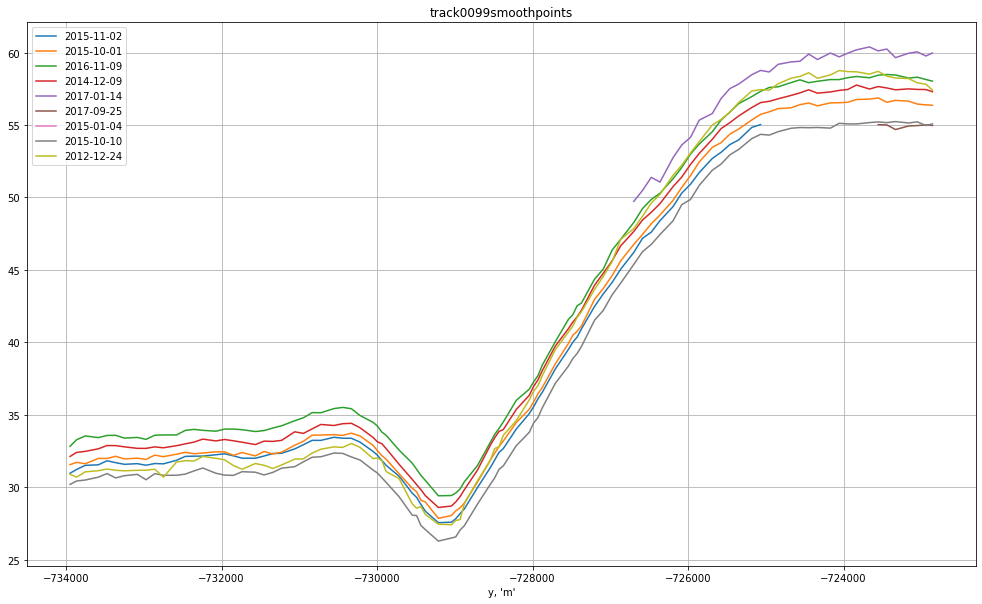

In [34]:
plot_line('track0099smoothpoints',x_or_y='y')

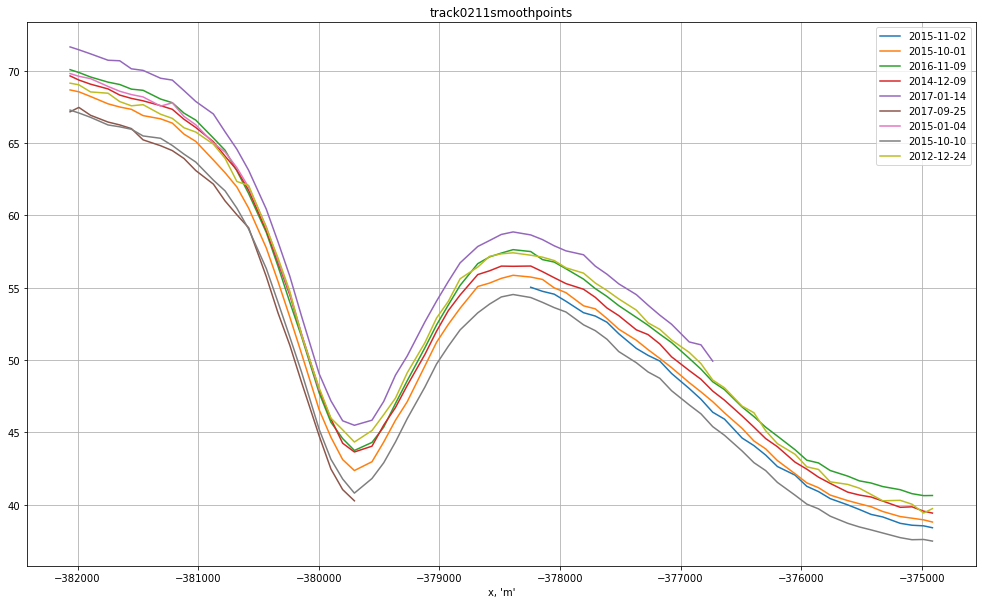

In [31]:
plot_line('track0211smoothpoints',x_or_y='x')

# Next add the icesat1 lines

In [24]:

def plot_line_REMA_icesat1(line_name, df=df,x_or_y='x',legend='date', remove_trend=False,lr=False):
    """
    Plots the icesat1line with REMA elevations.
    each elevation line has a linear line between first and last points removed, to try and reduce tide effects.
    only use this on lines perpendicular to channel
    """
    #rema_lines
    x_or_y_smooth = x_or_y + '_smooth'
    leg = []
    rl = gpd.read_file(gis_path+line_name+".shp")
    plt.figure(figsize=(17,10))
    for REMA in ld[line_name]:
        
        nid = int(REMA.split('_')[1])
        date = df.loc[nid].acquisitio
        #whether to flip line lr
        if (rl.geometry.x.iloc[0] - rl.geometry.x.iloc[-1]) < 0:
            lr=False
        else:
            lr=True
        
        if lr==True:
            remaline =  rl[REMA].iloc[::-1]
        else:
            remaline =  rl[REMA]
        if remove_trend==True:
            #make line from first to last point
            f = interpolate.interp1d( [rl[x_or_y_smooth].iloc[0],rl[x_or_y_smooth].iloc[-1]], [rl[REMA].iloc[0],rl[REMA].iloc[-1]])
            trendline = f(rl[x_or_y_smooth])
            if lr==True:
                plt.plot(rl[x_or_y_smooth],remaline-trendline[::-1])
            else:
                plt.plot(rl[x_or_y_smooth],remaline-trendline)
                    
        else:
            plt.plot(rl[x_or_y_smooth],remaline)
        plt.title(line_name)
        if legend=='date':
            leg.append(date)
        elif legend=='nid':
            leg.append(nid)
    
    #icesat1 lines
    for 
    
    
    plt.legend(leg) 
    plt.grid(True)
    plt.xlabel(f"{x_or_y}, (m)")
#     plt.xlim([-200,4500])
#     plt.ylim([-18,2])
    plt.show()
  

In [41]:
df0099 = pd.read_pickle('/Users/home/whitefar/DATA/REMOTE_SENSING/ICESAT1/zps_track0099.pkl')

In [43]:
df0099.keys()

Index(['x', 'pass_num', 'y', 'bin_number', 'dzdt', 'elev_wgs84_tpxtide',
       'grad', 'ret', 'retide', 'sdatedays', 'z', 'UTCtime', 'timestamp', 'zp',
       'residual', 'dz', 'geometry', 'zp_2004-05-31', '2004-05-31',
       'dzdt_2004-05-31', 'dzdt_cum_2004-05-31', 'zp_2005-06-02', '2005-06-02',
       'dzdt_2005-06-02', 'dzdt_cum_2005-06-02', 'zp_2005-11-03', '2005-11-03',
       'dzdt_2005-11-03', 'dzdt_cum_2005-11-03', 'zp_2006-03-07', '2006-03-07',
       'dzdt_2006-03-07', 'dzdt_cum_2006-03-07', 'zp_2006-06-06', '2006-06-06',
       'dzdt_2006-06-06', 'dzdt_cum_2006-06-06', 'zp_2006-11-06', '2006-11-06',
       'dzdt_2006-11-06', 'dzdt_cum_2006-11-06', 'zp_2008-03-01', '2008-03-01',
       'dzdt_2008-03-01', 'dzdt_cum_2008-03-01', 'zp_2008-10-16', '2008-10-16',
       'dzdt_2008-10-16', 'dzdt_cum_2008-10-16', 'zp_2008-11-26', '2008-11-26',
       'dzdt_2008-11-26', 'dzdt_cum_2008-11-26', 'zp_2009-03-21', '2009-03-21',
       'dzdt_2009-03-21', 'dzdt_cum_2009-03-21'],
      dty

# Next look at the rate of change